# Домашнее задание "Корреляционный и регрессионный анализ"

**Инструкции:**
- Скачайте файл `practical_module_dataset.csv` и заполните ячейки с заданиями кодом и выводами.
- В каждой задаче требуется:
  - короткая формулировка метода и обоснование,
  - код/расчёты,
  - результаты (коэффициенты, статистики, p-value, CI, R²),
  - промежуточный вывод.
- Используйте `numpy`, `pandas`, `scipy`, `statsmodels` или `scikit-learn` по желанию. При необходимости предобработки данных (очистка, удаление пропусков) укажите свои действия.
- Для воспроизводимости задан `np.random.seed` - не меняйте его!

**Формат сдачи:** `.ipynb` с заполненными ячейками, кодом и выводами.

In [69]:
# ячейка с импортами - дополняйте по своему желанию!
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
from scipy import stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

np.random.seed(28)

In [70]:
df = pd.read_csv('C:/Users/U_M1P8G/Desktop/IDE\Мат. статистика/practical_module_dataset.csv')
print(df.shape)
df.head()

(30, 8)


,id,age,height_cm,weight_kg,iq,tv_hours,study_hours,score
0,1,24,155.2,51.37,91,11,11.9,76.5
1,2,37,184.9,76.49,90,15,4.0,65.4
2,3,32,169.8,64.24,98,6,10.6,78.2
3,4,28,173.6,68.22,88,9,9.2,75.6
4,5,25,174.2,73.80,102,8,8.0,75.1


### Задание 1.
Выполните первичный анализ данных (EDA):
1. посмотрите на `describe()` для всех переменных,
2. проверьте наличие пропусков и типы данных через `info()`,
3. запишите наблюдения в текстовой ячейке.

In [71]:
# 1. Посмотрим на describe() для всех переменных
df.describe()

,id,age,height_cm,weight_kg,iq,tv_hours,study_hours,score
count,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000,30.000000
mean,15.500000,29.400000,169.153333,62.734000,100.433333,12.266667,7.640000,73.400000
std,8.803408,6.672641,9.584101,9.201488,12.119188,3.832109,3.281568,8.253693
min,1.000000,18.000000,148.200000,44.750000,82.000000,6.000000,2.700000,58.900000
25%,8.250000,24.250000,163.250000,56.622500,91.000000,9.000000,4.975000,67.800000
50%,15.500000,29.000000,169.750000,63.675000,97.000000,12.000000,7.650000,74.300000
75%,22.750000,35.500000,174.100000,68.602500,109.750000,14.000000,9.450000,78.725000
max,30.000000,39.000000,185.800000,81.130000,132.000000,22.000000,14.400000,91.500000


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30 entries, 0 to 29
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           30 non-null     int64  
 1   age          30 non-null     int64  
 2   height_cm    30 non-null     float64
 3   weight_kg    30 non-null     float64
 4   iq           30 non-null     int64  
 5   tv_hours     30 non-null     int64  
 6   study_hours  30 non-null     float64
 7   score        30 non-null     float64
dtypes: float64(4), int64(4)
memory usage: 2.0 KB
None


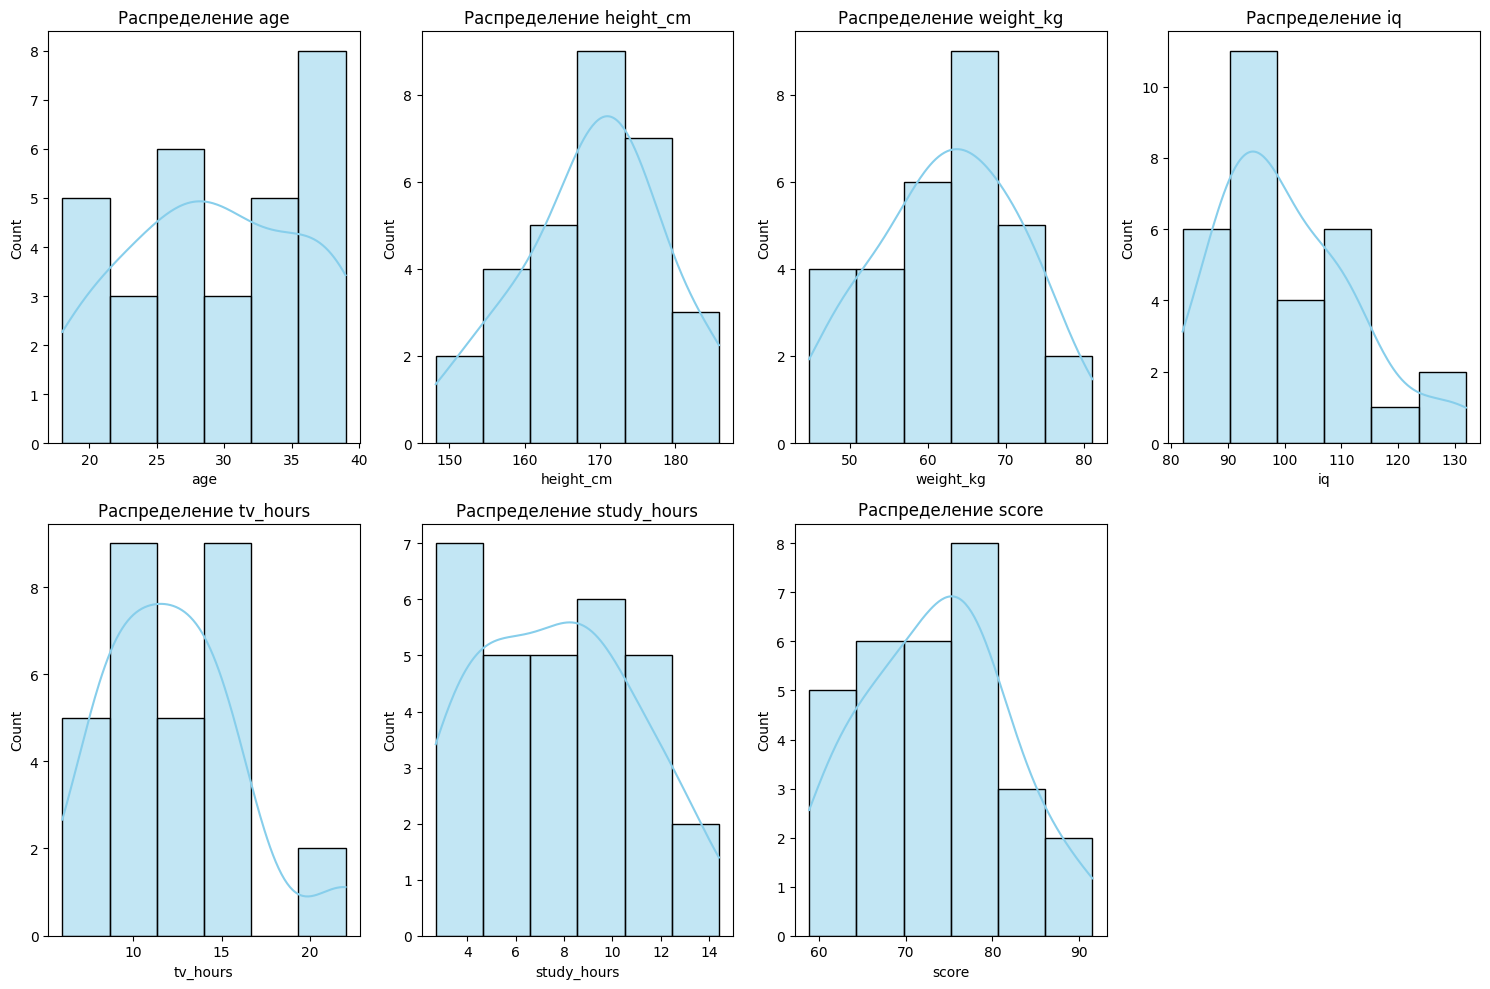

In [72]:
# 2. Проверим наличие пропусков и типы данных через info()
print(df.info())

# 3. Построим гистограммы по каждому признаку (кроме id)
import seaborn as sns
plt.figure(figsize=(15, 10))
columns_to_plot = df.columns.drop('id')
for i, col in enumerate(columns_to_plot, 1):
    plt.subplot(2, 4, i)
    sns.histplot(data=df, x=col, kde=True, bins=6, color='skyblue', edgecolor='black')
    plt.title(f'Распределение {col}')
    plt.tight_layout()

plt.show()

Наблюдения:

1. Перед нами таблица из 30 строк и 8 столбцов. Пропуски отсутствуют. Данные в 4 столбцах имеют тип целого числа (id человека, возраст, iq, tv_hours). В остальных столбцах тип данных - число с плавающей точкой.

2. Столбец id для анализа не информативен - это просто идентификатор
3. Возраст: Все возрасты находятся в диапазоне 18-39 лет, т.е. укладываются в диапазон +-3сигма, выбросов нет.
Группы по возрасту неоднородны. Самый высокий пик в диапазоне примерно 36-40. Распределение отличается от нормального.
4. Рост: медиана близка к среднему значению. Разброс типичный для взрослых людей, аномалий не наблюдается.
Распределение похоже на нормальное, колоколообразное с одним пиком. Но есть небольшая асимметрия - пик немного смещен вправо от центра. Это говорит о том, что большинство людей выше середины интервала. При этом очень высоких людей мало, но есть несколько человек роста заметно ниже среднего. 
5. Вес: пик находится примерно 55-65 кг. Распределение выглядит симметричным, аномалий не найдено.
Распределение выглядит нормальным визуально, но для утверждения о нормальности лучше провести доп. тесты
6. iq: распределение имеет сильную асимметрию: пик смещен влево от центра. При этом выбросов не обнаружено (изолированных столбцов нет, все данные укладываются в диапазон +-3 сигмы). Наблюдаемая асимметрия говорит о том, что есть люди с iq существенно выше среднего.
Распределение отличается от нормального.
7. tv_hours: Распределение не похоже на нормальное- есть 2 пика (примерно 7-10 часов и 14-16 часов), не колоколообразное. Найден изолированный столбец, похожий на потенциальный выброс (22 часа). Несмотря на то, что формально это значение находится внутри диапазона +-3 сигмы, изолированность значения может свидетельствовать о потенциальном экстремальном значении.
8. study_hours: распределение не похоже визуально на нормальное. Распределение не симметричное -  явный пик находится в области малых значений -  3-4 часа. Признак принимает значения от 2.7 до 14.4 часов в неделю, среднее ок. 7.6 часов. Преобладают люди, которые тратят меньше часов на обучение, чем люди с высоким количеством потраченных на учебу часов. Несмотря на то, что медиана близка к среднему, симметрии визуально мы не наблюдаем.
Аномалий не обнаружено
9. score: среднее значение балл ок. 73.4, что немного меньше медианы. На графике это визуализируется как асимметрия при более высокой частоте низких баллов. Аномалий не обнаружено


### Задание 2.
1. Постройте scatter plot по признакам `height_cm` и `weight_kg`.
2. Посчитайте коэффициент Пирсона между `height_cm` и `weight_kg` и выведите его на экран.
3. Интерпретируйте результат и запишите в виде мини-вывода.

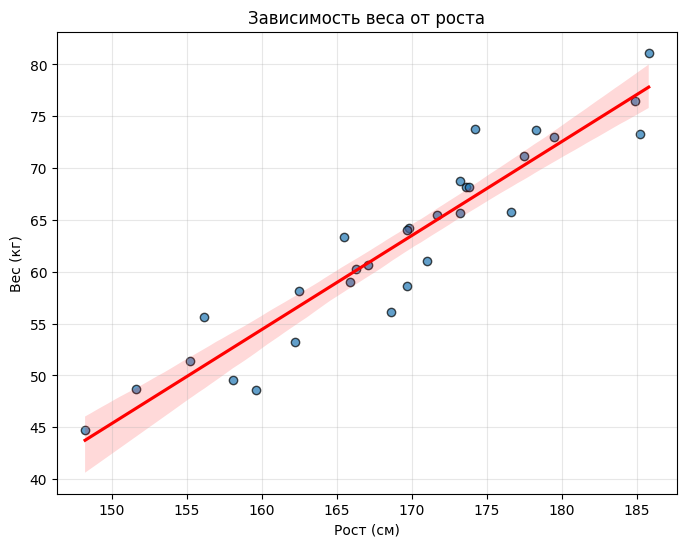

In [73]:
# 1. Построим scatter plot по признакам `height_cm` и `weight_kg`.
# добавим линию регрессии

plt.figure(figsize=(8, 6))
sns.regplot(x='height_cm', y='weight_kg', data=df, 
            scatter_kws={'alpha': 0.7, 'edgecolor': 'black'},
            line_kws={'color': 'red'})
plt.xlabel('Рост (см)')
plt.ylabel('Вес (кг)')
plt.title('Зависимость веса от роста')
plt.grid(True, alpha=0.3)
plt.show()

In [74]:
# Посчитаем коэффициент Пирсона между `height_cm` и `weight_kg':
corr_h_w, p = stats.pearsonr(df['height_cm'], df['weight_kg'])
print(f"Коэффициент корреляции Пирсона между ростом и весом: {corr_h_w:.3f}")
print(f"p-value: {p:.16f}")

Коэффициент корреляции Пирсона между ростом и весом: 0.944
p-value: 0.0000000000000058


Выводы:
1. Визуально на графике видим линейную прямую связь между ростом и весом - чем больше рост, тем больше вес.
Также видим, что точки тесно группируются вокруг линии регрессии, явных выбросов нет.
2. Коэффициент Пирсона очень высок - 0.944, что говорит о сильной тесной прямой линейной зависимости. При этом малый p-value говорит о статистической значимости результата.

### Задание 3.
1. Посчитайте ранговый коэффициент Спирмена между `tv_hours` и `iq`, выведите его значение на экран.
2. Оцените, есть ли связь? Запишите наблюдения в виде короткого вывода.

In [75]:
corr, p = stats.spearmanr(df['tv_hours'], df['iq'])
print(f"Коэффициент Спирмена: {corr:.3f}, p-value = {p:.6f}")

Коэффициент Спирмена: -0.211, p-value = 0.263541


Выводы и интерпретация:

1. Коэффициент Спирмена устойчив к выбросам (что важно при потенциальном выбросе в 22 часа tv_hours), поэтому очищать данные от выбросов нет необходимости.

2. Наблюдается слабая (к-т Спирмена менее 0.3 по модулю) обратная (отрицательный к-т Спирмена) монотонная связь между iq и количеством часов просмотра телевизора. Однако эта зависимость не является статистически значимой (p-value > 0.05), мы могли получить такой результат случайно.

### Задание 4.
1. Постройте простую линейную регрессию `weight_kg ~ height_cm`.
2. Найдите и выведите оценки коэффициентов (intercept и slope).
3. Рассчитайте и вывдите 95% доверительный интервал для наклона.
4. Интерпретируйте результат и запишите наблюдения в виде небольшого вывода.

In [ ]:
# 1. Построим простую линейную регрессию между признаками роста и веса

X_sm = sm.add_constant(df['height_cm'])
model_sm = sm.OLS(df['weight_kg'], X_sm).fit()


# 2. Выведем оценки коэффициентов
print("Коэффициенты линейной регрессии:")
print(f"Intercept: {model_sm.params['const']:.3f}")
print(f"Slope: {model_sm.params['height_cm']:.3f}")

# 3. Рассчитаем 95% доверительный интервал для наклона

conf_int = model_sm.conf_int(alpha=0.05)
print(f"95% ДИ для наклона: [{conf_int.loc['height_cm', 0]:.4f}, {conf_int.loc['height_cm', 1]:.4f}]")


Коэффициенты линейной регрессии:
Intercept: -90.496
Slope: 0.906
95% ДИ для наклона: [0.7827, 1.0290]


Выводы:
1. Коэффициент наклона положительный, что соответствует ранее сделанному выводу о наблюдаемом увеличении веса при увеличении роста.
Значение 0,906 означает, что по нашей выборке каждый 1 см роста добавляет 0,906 кг веса.

2. Доверительный интервал коэффициента наклона можно интерпретировать следующим образом:
- мы на 95% убеждены, что истинное значение коэффицента находится в пределах от 0.7827 до 1.029
- значение "0" не находится внутри интервала, т.е. статистически значимой является прямая линейная связь между ростом и весом

3. Intercept принимает отрицательное значение -90.496 - теоретический вес при нулевом росте/точка пересечения линии регрессии с осью y. Физически не интерпретируемо (нет людей с нулевым ростом, отрицательное значение веса также не может быть). В нашем случае это просто технический параметр, необходимый для более высокой точности модели.


### Задание 5.
Для `height_cm = 175`:
1. вычислите предсказание веса,
2. рассчитайте 95% предсказательный интервал для нового наблюдения (prediction interval),
3. запишите небольшой вывод.

In [78]:
# 1. Вычислим предсказание веса
pred = model_sm.get_prediction([1, 175])
print(f"Предсказание: {pred.predicted_mean[0]:.1f} кг")
pi = pred.conf_int(obs=True, alpha=0.05)


print(f"95% предсказательный интервал для роста 175 см: [{pi[0][0]:.1f}, {pi[0][1]:.1f}] кг")

Предсказание: 68.0 кг
95% предсказательный интервал для роста 175 см: [61.5, 74.5] кг


Получили предсказание веса равное 68 кг для роста 175 см. Результат выглядит правдоподобным.

95% предсказательный интервал  - от 61,5 кг до 74,5 кг. С вероятностью 95% вес конкретного человека такого роста будет находиться в этих пределах. Ширина интервала 13 кг отражает естественную вариацию веса при одинаковом росте 175 см.


### Задание 6.
1. Постройте множественную регрессию `score ~ study_hours + iq + tv_hours + age`.
2. Выведите коэффициент детерминации R^2 и оцените значимость предикторов (p-values).
3. Запишите наблюдения в вывод.

In [79]:
# 1. Построим множественную регрессию `score ~ study_hours + iq + tv_hours + age`
X = df[['study_hours', 'iq', 'tv_hours', 'age']]
y = df['score']
X = sm.add_constant(X)
model_4_factors = sm.OLS(y, X).fit()
# выведем основную информацию о полученной модели
print(model_4_factors.summary().tables[1])

# 2. Выведем коэффициент детерминации и оценим значимость предикторов
# Коэффициент детерминации
print(f"\nКоэффициент детерминации R²: {model_4_factors.rsquared:.4f}")
print(f"Скорректированный R²: {model_4_factors.rsquared_adj:.4f}")

# p-value  для каждого предиктора
print("\nP-value предикторов:")
for col in ['study_hours', 'iq', 'tv_hours', 'age']:
    p_value = model_4_factors.pvalues[col]
    significance = 'значим' if p_value < 0.05 else 'не значим'
    print(f"{col:12s}: p-value = {p_value:.4f} {significance}")

                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          45.6584      6.807      6.708      0.000      31.639      59.678
study_hours     2.0978      0.193     10.848      0.000       1.700       2.496
iq              0.1479      0.053      2.785      0.010       0.039       0.257
tv_hours       -0.1447      0.159     -0.913      0.370      -0.471       0.182
age            -0.0465      0.091     -0.511      0.614      -0.234       0.141

Коэффициент детерминации R²: 0.8741
Скорректированный R²: 0.8539

P-value предикторов:
study_hours : p-value = 0.0000 значим
iq          : p-value = 0.0101 значим
tv_hours    : p-value = 0.3702 не значим
age         : p-value = 0.6141 не значим


1. Коэффициент детерминации:
   - т.к. факторов более 2, предлагаю ориентироваться на скорректированный к-т детерминации, который "штрафует" за добавление "лишних" признаков в модель
   - скорректированный R^2 равен ок. 0.85, что в целом приемлемо, но результат можно было бы улучшить (например, убрав "лишние" признаки, увеличив объем выборки, добавив признаки с более тесной связью с целевой переменной (если такие будут найдены))

2. Анализ предикторов:
- на основании p-value можно сделать вывод о том, что статистически значимая связь между предиктором и score наблюдается по двум переменным: study_hours и iq. Зависимость прямая по обеим переменным (чем выше значение признаков, тем выше score). Причем наиболее важным признаком является study_hours (коэффициент наклона при нем существенно выше, чем при переменной iq. Каждый час учебы прибавляет ок. + 2.1 балла).
- по признакам 'tv_hours' и 'age' коэффициенты имеют отрицательные знаки (чем меньше значение признаков, тем выше скор), однако результат не является статистически значимым (p-value более 0.05). Мы могли получить такой результат случайно. 

Рекомендовано исключить признаки 'tv_hours' и 'age' из модели

### Задание 7.
1. Разделите данные на train/test (70/30), используйте `random_state=42`.
2. Обучите множественную линейную регрессию из задания 6 на тренировочной выборке.
3. И оцените RMSE на тестовой выборке - выведите её на экран.
4. Насколько модель хорошо предсказывает целевую переменную?

In [80]:
#1. Разделим данные на train/test (70/30), используя `random_state=42':

X_train, X_test, y_train, y_test = train_test_split(
    df[['study_hours', 'iq', 'tv_hours', 'age']], 
    df['score'], 
    test_size=0.3, 
    random_state=42
)
#2. Обучим множественную линейную регрессию из задания 6 на тренировочной выборке
from sklearn.linear_model import LinearRegression
model = LinearRegression().fit(X_train, y_train)

# Оценим RMSE на тестовой выборке
rmse = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))
print(f"RMSE: {rmse:.4f}")

RMSE: 3.7936


In [81]:
# Дополнительно сравним полученный RMSE с еще двумя вариантами модели:
# Вариант 1 - избавимся от незначимых признаков (tv_hours и age)
# Вариант 2 - оставим только 1 признак - study_hours

results = []
feature_sets = [
    (['study_hours', 'iq', 'tv_hours', 'age'], "Полная модель"),
    (['study_hours', 'iq'], "Только study_hours + iq"),
    (['study_hours'], "Только study_hours")
]


for features, description in feature_sets:
    model = LinearRegression()
    model.fit(X_train[features], y_train)
   
    y_pred = model.predict(X_test[features])
    
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    
    results.append({
        'Признаки': ', '.join(features),
        'Кол-во признаков': len(features),
        'RMSE': rmse
    })

# Вывод результатов
results_df = pd.DataFrame(results)
print("Сравнение моделей линейной регрессии:")
print(results_df.to_string(index=False))

Сравнение моделей линейной регрессии:
                      Признаки  Кол-во признаков     RMSE
study_hours, iq, tv_hours, age                 4 3.793554
               study_hours, iq                 2 3.364089
                   study_hours                 1 3.603435


Выводы:
1. Модель из 4 признаков показывает хорошее качество предсказания с RMSE = 3.79 балла на тестовой выборке. Т.е. в среднем предсказания отличаются от фактических результатов на 3.79 балла, что составляет менее половины стандартного отклонения (8.25). Модель на точнее, чем простое предсказание средним значением. Такая точность достаточна для аналитических целей, но может быть недостаточной для индивидуального прогнозирования с высокой точностью

2. Проведено сравнение с 2 вариантами моделей: вариант 1 - оставили только значимые признаки. Вариант 2 - оставили только самый весомый признак (кол-во часов обучения).
Наилучший по RMSE результат показа вариант с 2 признаками (study_hours, iq) - RMSE 3.36 балла, что на ок. 0.4 балла лучше исходного результата. 

### Задание 8.
1. Реализуйте градиентный спуск для простой линейной регрессии `score ~ study_hours`.
2. Сравните полученные коэффициенты со `statsmodels`.

PS: выведите коэффициенты в обоих случаях на экран.

In [82]:
# Реализуем градиентный спуск для простой линейной регрессии `score ~ study_hours`

x = df['study_hours']
y = df['score']

# инициализация
w = 0.0
intercept_ = 0.0
learning_rate_ = 0.01
n_iter = 2000
n = len(x)

for epoch in range(n_iter):
    # предсказание
    y_hat = w * x + intercept_
    # градиенты для MSE (с фактором 2/n)
    grad_w = (-2.0/n) * np.sum(x * (y - y_hat))
    grad_intercept_ = (-2.0/n) * np.sum(y - y_hat)
    # обновление
    w -= learning_rate_ * grad_w
    intercept_ -= learning_rate_ * grad_intercept_

print("Градиентный спуск:\nw, intercept:", round(w,3), round(intercept_,3))

#2. Сравним полученные коэффициенты со `statsmodels`
model = sm.OLS(df['score'], sm.add_constant(df['study_hours'])).fit()
sm_w = round(model.params['study_hours'], 6)
sm_intercept = round(model.params['const'], 6)

print("\nStatsmodel:\nw, intercept:", round(sm_w, 3), round(sm_intercept, 3))



Градиентный спуск:
w, intercept: 2.288 55.896

Statsmodel:
w, intercept: 2.273 56.034


Сравнение полученных коэффициентов:
1. Коэффициенты (w, intercept), полученные ручной реализацией градиентного спуска, близки к результату statsmodel, что подтверждает корректность реализации градиентного спуска.

2. Небольшая разница обусловлена тем, что градиентный спуск мог не дойти до глобального минимума (из-за недостаточного числа итераций или слишком большого значения learning_rate).

3. Для уточнения результата градиентого спуска можно скорректировать параметры (увеличить количество итераций/уменьшить learning_rate). Но в целом результат хорош, можно использовать.

### Задание 9.
Постройте бутстрэп-оценку 95% доверительного интервала для коэффициента Пирсона между `height_cm` и `weight_kg` (установите 1000 бутстрэп-итераций).

Выведите границы ДИ на экран.

In [83]:
x = df['height_cm'].values
y = df['weight_kg'].values
n = len(x)

n_bootstrap = 1000
bootstrap_corrs = []

for i in range(n_bootstrap):
    # сгенерируем бутстрэп-выборку:
    indices = np.random.choice(n, size=n, replace=True)
    x_boot = x[indices]
    y_boot = y[indices]
    
    # вычислим коэффициент Пирсона для бутстрэп-выборки
    corr = np.corrcoef(x_boot, y_boot)[0, 1]
    bootstrap_corrs.append(corr)

# вычислим 95% доверительный интервал (перцентильный метод)
ci_lower = np.percentile(bootstrap_corrs, 2.5)
ci_upper = np.percentile(bootstrap_corrs, 97.5)


print(f"Исходный коэффициент: {corr_h_w:.4f}")
print(f"95% ДИ (перцентильный метод): [{ci_lower:.4f}, {ci_upper:.4f}]")

Исходный коэффициент: 0.9435
95% ДИ (перцентильный метод): [0.9021, 0.9705]


Истинный коэффициент корреляции с вероятностью 95% находится в интервале от 0.9037 до 0.9738. 
Это говорит о том, что:
1. Линейная связь между ростом и весом статистически значима (в интервал не входит 0)
2. Теснота связи сильная, т.к. нижняя граница интервала выше 0.9

Метод Бутстрэп-оценки хорош тем, что:
- не предполагает нормальности распределения
- подходит в условиях ограниченности объема выборок (как в нашем случае, где n всего 30 наблюдений), хотя при малых n точность может снижаться

### Задание 10.
Постройте гистограмму остатков (residuals) для модели из задания 6.

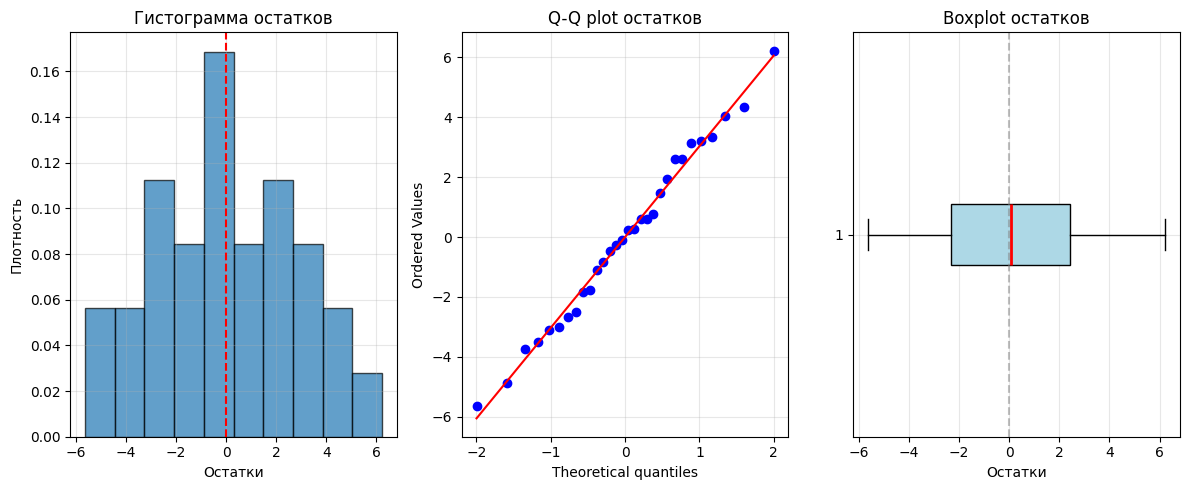

Тест Shapiro-Wilk на нормальность остатков:
Статистика: 0.9866, p-value: 0.9616


In [85]:

fig, axes = plt.subplots(1, 3, figsize=(12, 5))

# 1. Построим гистограмму остатков для модели из задания 6

axes[0].hist(model_4_factors.resid, bins=10, edgecolor='black', alpha=0.7, density=True)
axes[0].axvline(x=0, color='red', linestyle='--')
axes[0].set_xlabel('Остатки')
axes[0].set_ylabel('Плотность')
axes[0].set_title('Гистограмма остатков')
axes[0].grid(True, alpha=0.3)

# 2. Используем Q-Q plot для проверки нормальности
stats.probplot(model_4_factors.resid, dist="norm", plot=axes[1])
axes[1].set_title('Q-Q plot остатков')
axes[1].grid(True, alpha=0.3)


# 3. Boxplot
axes[2].boxplot(model_4_factors.resid, vert=False, patch_artist=True,
                boxprops=dict(facecolor='lightblue'),
                medianprops=dict(color='red', linewidth=2),
                flierprops=dict(marker='o', markerfacecolor='red', markersize=8))
axes[2].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
axes[2].set_xlabel('Остатки')
axes[2].set_title('Boxplot остатков')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Дополнительно проведем тест Shapiro-Wilk для проверки нормальности
stat, p_value = stats.shapiro(model_4_factors.resid)
print(f"Тест Shapiro-Wilk на нормальность остатков:")
print(f"Статистика: {stat:.4f}, p-value: {p_value:.4f}")

Выводы:
1. Остатки распределены нормально, что следует из:
   - формы распределения - колоколообразная, симметричная с пиком в центре около нуля
   - Q-Q plot остатков показывает схожесть распределения с нормальным (точки близки к диагонали)
   - тест Shapiro-Wilk не отвергает гипотезу о нормальности
2. На boxplot наглядно видно, что систематических смещений нет (среднее остатков около нуля), выбросов не обнаружено. Модель адекватна

Удачи! Сохраните ноутбук, перезапустите все ячейки от начала до конца и прикрепите файл как ответ.